Ideal Output & Deliverables

The ideal output of this project will be:
A dashboard that implements predictive models to find what helps/harms a student's progression through school. 
A final report answers the Base Question:
What are the best predictors of student retention (i.e., the prevention of student dropouts)?

https://docs.google.com/document/d/1XHfDhUMD1c868baqg_8Kk4j2PJzwHRX8Psf7PTKLgss/edit?tab=t.0

In [2]:
import pandas as pd
import numpy as np

# Philippines Data

### Load in Data

In [5]:
df_Philippines = pd.read_excel("/Users/matthewmaslow/Desktop/ds-save-the-children/Retention_Philippines/Philippines CuC Data - 2024 10 03.xlsx",
                                       sheet_name="_fact_student_attendance")
df_Philippines_ADD = pd.read_excel("/Users/matthewmaslow/Desktop/ds-save-the-children/Retention_Philippines/Philippines - Additional Data - 2024 10 23.xlsx")

In [6]:
# Merge the DataFrames with custom suffixes
df_Philippines = df_Philippines.merge(
    df_Philippines_ADD, 
    on='ChildrenId', 
    how='left', 
    suffixes=('', '_dup')
)
for column in df_Philippines.columns:
    if column.endswith('_dup'):
        original_col = column[:-4]
        df_Philippines[original_col] = df_Philippines[original_col].combine_first(df_Philippines[column])
        df_Philippines.drop(columns=[column], inplace=True)
df_Philippines.info()

/var/folders/sf/c0xndf0951l35zqvq0zt2vy00000gn/T/ipykernel_89268/1438318490.py:11: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df_Philippines[original_col] = df_Philippines[original_col].combine_first(df_Philippines[column])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292766 entries, 0 to 292765
Data columns (total 37 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   Month                    292766 non-null  datetime64[ns]
 1   GradeId                  292766 non-null  int64         
 2   StudentIsPresent         292766 non-null  bool          
 3   ReasonType               62187 non-null   object        
 4   StudentAbsenseReason     62187 non-null   object        
 5   StudentAttendanceDate    292766 non-null  datetime64[ns]
 6   ClassID                  292766 non-null  int64         
 7   ChildrenId               292766 non-null  int64         
 8   SchoolId                 292766 non-null  int64         
 9   AcademicYearId           292766 non-null  float64       
 10  AcademicYearName         292670 non-null  object        
 11  Year                     292766 non-null  float64       
 12  Gender          

In [7]:
df_Philippines.head()

,Month,GradeId,StudentIsPresent,ReasonType,StudentAbsenseReason,StudentAttendanceDate,ClassID,ChildrenId,SchoolId,AcademicYearId,...,SomeoneToTalkWhenStress,TellFamilyWhenStress,FeelingSad,HowResolveProblem,WhoResolveProblem,OtherLanguangeAtHome,Project,Cycle,AssessorID,DistrictID
0,2023-05-01,14,True,NaN,NaN,2023-05-08,557,4508,89,7.0,...,3. Don’t know,3. Don’t know,NaN,3. Don’t know,1. Yes,NaN,Sarangani,1.0,345.0,2.0
1,2023-05-01,14,True,NaN,NaN,2023-05-08,557,4518,89,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,Sarangani,1.0,345.0,2.0
2,2023-05-01,14,True,NaN,NaN,2023-05-08,557,4518,89,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,Sarangani,1.0,384.0,2.0
3,2023-05-01,14,True,NaN,NaN,2023-05-08,557,4518,89,7.0,...,Yes,Yes,Yes,Yes,Yes,NaN,Sarangani,1.0,345.0,2.0
4,2023-05-01,14,True,NaN,NaN,2023-05-08,557,4518,89,7.0,...,1. Yes,2. No,NaN,2. No,1. Yes,NaN,Sarangani,1.0,384.0,2.0


### Data Prep

In [9]:
# Convert boolean column(s) to int64 (False = 0, True = 1)
boolean_columns = df_Philippines.select_dtypes(include='bool').columns
df_Philippines[boolean_columns] = df_Philippines[boolean_columns].astype(int)

In [10]:
# Fixing faulty entries in columns.....
#   ['SomeoneToTalkWhenStress', 'SpendTimeWithFamily', 'TellFamilyWhenStress', 'HowResolveProblem', 'WhoResolveProblem']
who_resolve_problem_map = {
    'Yes': 'Yes',
    '1. Yes': 'Yes',
    '2. No': 'No',
    'No': 'No',
    '3. Don’t know': 'Don’t know',
    'Refuse to answer': 'Refuse to answer'
}

columns_to_clean = ['SomeoneToTalkWhenStress', 'SpendTimeWithFamily', 'TellFamilyWhenStress', 'HowResolveProblem', 'WhoResolveProblem']

for col in columns_to_clean:
    df_Philippines[col] = df_Philippines[col].replace(who_resolve_problem_map)

for col in columns_to_clean:
    print(f"{col} counts:\n{df_Philippines[col].value_counts()}\n")

SomeoneToTalkWhenStress counts:
SomeoneToTalkWhenStress
Yes                 54657
No                  10956
Don’t know           2997
Refuse to answer     2178
Name: count, dtype: int64

SpendTimeWithFamily counts:
SpendTimeWithFamily
Yes                 68213
Refuse to answer     1470
No                   1056
Don’t know            207
Name: count, dtype: int64

TellFamilyWhenStress counts:
TellFamilyWhenStress
Yes                 54231
No                  11365
Don’t know           2868
Refuse to answer     2142
Name: count, dtype: int64

HowResolveProblem counts:
HowResolveProblem
Yes                 39224
No                  19963
Don’t know           7493
Refuse to answer     4267
Name: count, dtype: int64

WhoResolveProblem counts:
WhoResolveProblem
Yes                 59442
Don’t know           4573
No                   3492
Refuse to answer     3474
Name: count, dtype: int64



In [11]:
# converting date columns to make them numeric
df_Philippines = df_Philippines.drop(columns=["Month"])
df_Philippines['Month'] = df_Philippines['StudentAttendanceDate'].dt.month
df_Philippines['Day'] = df_Philippines['StudentAttendanceDate'].dt.day
df_Philippines['Year'] = df_Philippines['StudentAttendanceDate'].dt.year
df_Philippines = df_Philippines.drop(columns=["StudentAttendanceDate"])

In [12]:
file_path = '/Users/matthewmaslow/Desktop/ds-save-the-children/Retention_Philippines/df_Philippines_combined.xlsx'

df_Philippines.to_excel(file_path, index=False)

print(f"File saved successfully at {file_path}")


File saved successfully at /Users/matthewmaslow/Desktop/ds-save-the-children/Retention_Philippines/df_Philippines_combined.xlsx


In [13]:
file_path = '/Users/matthewmaslow/Desktop/ds-save-the-children/Retention_Philippines/df_Philippines_combined.csv'

df_Philippines.to_csv(file_path, index=False)

print(f"File saved successfully at {file_path}")


File saved successfully at /Users/matthewmaslow/Desktop/ds-save-the-children/Retention_Philippines/df_Philippines_combined.csv


In [14]:
df_Philippines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292766 entries, 0 to 292765
Data columns (total 37 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   GradeId                  292766 non-null  int64  
 1   StudentIsPresent         292766 non-null  int64  
 2   ReasonType               62187 non-null   object 
 3   StudentAbsenseReason     62187 non-null   object 
 4   ClassID                  292766 non-null  int64  
 5   ChildrenId               292766 non-null  int64  
 6   SchoolId                 292766 non-null  int64  
 7   AcademicYearId           292766 non-null  float64
 8   AcademicYearName         292670 non-null  object 
 9   Year                     292766 non-null  int32  
 10  Gender                   292766 non-null  object 
 11  RecordId                 292766 non-null  int64  
 12  ClassName                81752 non-null   object 
 13  ClassId                  81752 non-null   float64
 14  Chil

In [15]:
numeric_df_Philippines = df_Philippines.apply(pd.to_numeric, errors='coerce')
correlation_matrix = numeric_df_Philippines.corr()

target_correlation = correlation_matrix['StudentIsPresent'].sort_values(ascending=False)
target_correlation


StudentIsPresent           1.000000
Day                        0.033811
IsCUCSatisfied?            0.009845
RecordId                  -0.002591
Month                     -0.003440
BirthOrder                -0.005879
AssessorID                -0.007452
GradeId                   -0.009671
AcademicYearId            -0.012524
ClassID                   -0.013670
ClassId                   -0.017808
ChildrenId                -0.020473
SchoolId                  -0.037769
DistrictID                -0.060286
ChildrenAge               -0.089163
ReasonType                      NaN
StudentAbsenseReason            NaN
AcademicYearName                NaN
Year                            NaN
Gender                          NaN
ClassName                       NaN
ChildrenGender                  NaN
ChildrenDateOfBirth             NaN
Safety Status Category          NaN
WillingnessInCUC?               NaN
PrimaryCaregiver                NaN
LanguangeAtHome                 NaN
SpendTimeWithFamily         

In [16]:
import numpy as np
from scipy.stats import chi2_contingency
import pandas as pd

# Function to calculate Cramér's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))

# Updated categorical columns based on df_Philippines
categorical_columns = [
    "ReasonType",
    "StudentAbsenseReason",
    "AcademicYearName",
    "Gender",
    "ClassName",
    "ChildrenGender",
    "ChildrenDateOfBirth",
    "Safety Status Category",
    "WillingnessInCUC?",
    "BirthOrder",
    "PrimaryCaregiver",
    "LanguangeAtHome",
    "SpendTimeWithFamily",
    "CalmWhenStress",
    "SomeoneToTalkWhenStress",
    "TellFamilyWhenStress",
    "FeelingSad",
    "HowResolveProblem",
    "WhoResolveProblem",
    "OtherLanguangeAtHome",
    "Project"
]

# Fill missing values with the mode (most frequent value) for each categorical column
for col in categorical_columns:
    if df_Philippines[col].isnull().any():
        df_Philippines[col].fillna(df_Philippines[col].mode()[0], inplace=True)

# Calculate Cramér's V for each categorical column against 'StudentIsPresent'
cramers_v_results = {col: cramers_v(df_Philippines[col], df_Philippines['StudentIsPresent']) for col in categorical_columns}
cramers_v_results


/var/folders/sf/c0xndf0951l35zqvq0zt2vy00000gn/T/ipykernel_89268/3094654829.py:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_Philippines[col].fillna(df_Philippines[col].mode()[0], inplace=True)
/var/folders/sf/c0xndf0951l35zqvq0zt2vy00000gn/T/ipykernel_89268/3094654829.py:10: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))


{'ReasonType': 0.47821438500720936,
 'StudentAbsenseReason': 0.5435572549330345,
 'AcademicYearName': 0.012321603624462442,
 'Gender': 0.03321631588136081,
 'ClassName': 0.013824430038512003,
 'ChildrenGender': 0.01876476529590279,
 'ChildrenDateOfBirth': 0.01754407790759092,
 'Safety Status Category': 0.012562665094657807,
 'WillingnessInCUC?': 0.008376792875652185,
 'BirthOrder': 0.013835475514132575,
 'PrimaryCaregiver': 0.007826951432289396,
 'LanguangeAtHome': 0.02704632292237278,
 'SpendTimeWithFamily': 0.023265448872402845,
 'CalmWhenStress': 0.009419442940473154,
 'SomeoneToTalkWhenStress': 0.0191566709388103,
 'TellFamilyWhenStress': 0.021282455385293105,
 'FeelingSad': 0.017198444454691902,
 'HowResolveProblem': 0.009853404475343445,
 'WhoResolveProblem': 0.01928389216715916,
 'OtherLanguangeAtHome': 0.009840376573964343,
 'Project': nan}

### Model Training

In [18]:
# Set device based on GPU availability
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Utility function to transfer tensors to the selected device
def to_device(tensor):
    return tensor.to(device)

Using device: cpu


In [19]:
df_Philippines['StudentIsPresent'].value_counts()

StudentIsPresent
1    230579
0     62187
Name: count, dtype: int64

LogisticRegression....
Validation Accuracy: 0.98
Test Accuracy: 0.95
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.96      0.90     12425
           1       0.99      0.95      0.97     46129

    accuracy                           0.95     58554
   macro avg       0.92      0.96      0.93     58554
weighted avg       0.96      0.95      0.96     58554



/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


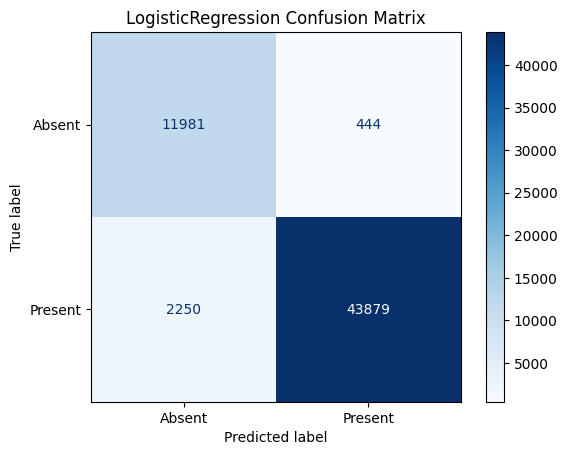

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


RandomForestClassifier....
Validation Accuracy: 0.80
Test Accuracy: 0.79
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.42      0.46     12425
           1       0.85      0.89      0.87     46129

    accuracy                           0.79     58554
   macro avg       0.68      0.66      0.66     58554
weighted avg       0.78      0.79      0.78     58554



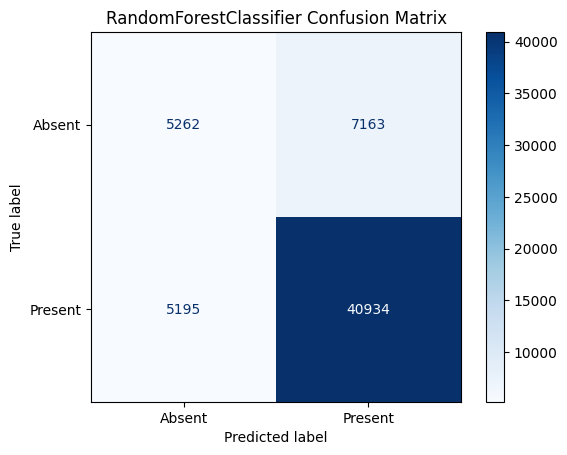



DecisionTreeClassifier....
Validation Accuracy: 0.81
Test Accuracy: 0.80
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.22      0.32     12425
           1       0.82      0.96      0.89     46129

    accuracy                           0.80     58554
   macro avg       0.71      0.59      0.60     58554
weighted avg       0.78      0.80      0.77     58554



/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


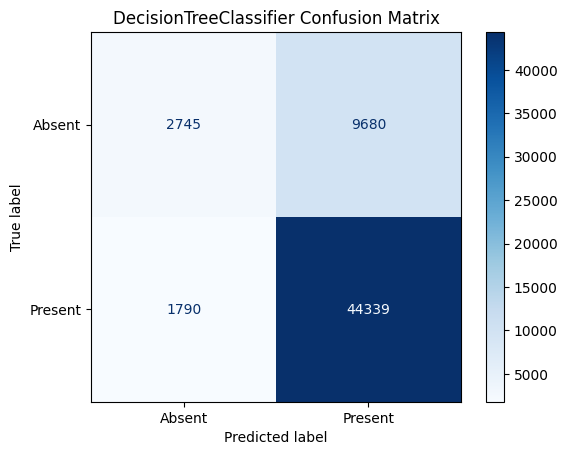

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt

predictors = [
    'GradeId',
    'ChildrenId',
    'RecordId',
    'AcademicYearName',
    'FeelingSad',
    'TellFamilyWhenStress',
    'Month',
    'Cycle'
]

df_Philippines_pred = df_Philippines[['StudentIsPresent'] + predictors]

transformer = make_column_transformer(
    (Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]), predictors),
    remainder="passthrough"
)

X = df_Philippines_pred.drop(columns=["StudentIsPresent"])
y = df_Philippines_pred["StudentIsPresent"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logistic_model = LogisticRegression(max_iter=1000, random_state=0, class_weight='balanced')
rf_model = RandomForestClassifier(
    random_state=0,
    class_weight='balanced',
    n_jobs=1,
    n_estimators=100,
    max_depth=25
)
dt_model = DecisionTreeClassifier(
    random_state=0,
    class_weight='balanced',
    max_depth=100,          
    min_samples_split=5,  
    min_samples_leaf=5        
)

def evaluate_model(model, X_train, X_test, y_train, y_test):
    pipeline = ImbPipeline([
        ('preprocessor', transformer),
        ('undersampler', RandomUnderSampler(sampling_strategy='not majority')),
        ('model', model)
    ])

    pipeline.fit(X_train, y_train)
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"{model.__class__.__name__}....")
    print(f"Validation Accuracy: {train_accuracy:.2f}")
    print(f"Test Accuracy: {test_accuracy:.2f}")

    print("Classification Report:")
    print(classification_report(y_test, y_test_pred))

    conf_matrix = confusion_matrix(y_test, y_test_pred)
    labels = ['Absent', 'Present']
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"{model.__class__.__name__} Confusion Matrix")
    plt.show()

    print("\n" + "="*50 + "\n")
    
evaluate_model(logistic_model, X_train, X_test, y_train, y_test)
evaluate_model(rf_model, X_train, X_test, y_train, y_test)
evaluate_model(dt_model, X_train, X_test, y_train, y_test)